In [1]:
import pandas
import requests #use requests over 'urllib.request'. Work-around for encoding problem. See: https://stackoverflow.com/questions/47419104/unicodedecodeerror-utf-8-codec-cant-decode-python3
import json
from geojson import MultiPoint
import folium
from folium import IFrame #folium does not have a .element object/attribute see https://github.com/python-visualization/folium/issues/774
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import mapping, shape
from shapely.wkt import dumps, loads

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import numpy as np
from scipy import special
from scipy.optimize import curve_fit

#for reading from databases
import json
import psycopg2
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *

import getpass
import datetime

import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
#connect to DB and download data
password = getpass.getpass(prompt='Password: ')
db_credentials_path = '/Users/Jacobus/Documents/Python/msu_denver_db_creds.json'
with open(db_credentials_path,'r') as f:
    db_conn_dict = json.load(f)
db_conn_dict['password'] = password

connection = psycopg2.connect(**db_conn_dict)

#read data from db
df_all = gpd.read_postgis("select * from gdelt_mentions", connection, 
                            geom_col='geom', crs={'init':'epsg:4326'},
                            coerce_float=False)


connection.close()

Password: ········


In [5]:
#get unique time slices
#this is redundant to df.groupby() function
time_periods = set(df_all.urlpubtimedate)
df_all['count'] = 1

#get sum of mentions per time slice group
df_sum = df_all.groupby('urlpubtimedate').sum()
df_sum
# df_sum.sumtotalmentions['2018-02-27 17:45:00']


#create new column in df_all that holds ratio of mentions to total mentions
def getSumMentions(dateTime):
    return df_sum.sumtotalmentions[dateTime]

#make new column containing the total mentions for that datetime slice
df_all['timedate_sum'] = df_all['urlpubtimedate'].apply(lambda x: getSumMentions(x))
#make new column for numMentions/totalMentions
df_all['normalized_mentions'] = df_all.sumtotalmentions/df_all.timedate_sum

#create column of proportion of mentions for each location over the entire mention total
df_all['proportion_of_total_mentions'] = df_all.sumtotalmentions / df_all.sumtotalmentions.sum()

In [6]:
#measure distance from max mentions proportion and plot

from geopy.distance import vincenty

# regression of mentions as a function of distance
# distance from 'hot spots'

#let's start with the top -- add a column for distance away from place with max ratio
# with geopandas: .distance(other) returns the min distance for each element in a series to other

max_row = df_all['proportion_of_total_mentions'].idxmax()
min_row = df_all.proportion_of_total_mentions.idxmin()
max_center = (df_all.loc[max_row].lat,df_all.loc[max_row].lon)
min_center = (df_all.loc[min_row].lat,df_all.loc[min_row].lon)

penult_row = df_all.drop(max_row).proportion_of_total_mentions.idxmax()
penult_center = (df_all.loc[penult_row].lat,df_all.loc[penult_row].lon)


#vincenty is happy when you input a lat,lon tuple
#please, make vincenty happy...
df_all['coordinates_yx'] = df_all.coordinates.apply(lambda x: (x.split(',')[-1][:-1],x.split(',')[0][1:]))

df_all['dist_from_max'] = df_all.coordinates_yx.apply(lambda x: vincenty(max_center,x).meters)
df_all['dist_from_penult'] = df_all.coordinates_yx.apply(lambda x: vincenty(penult_center,x).meters)

#get distances from major population centers


# see for great circle distance calculations: https://gis.stackexchange.com/questions/84885/whats-the-difference-between-vincenty-and-great-circle-distance-calculations
# use Vincenty's formula from geopy
#d=vincenty(p1, p2).meters


# df_all['distance_from_max_geopandas'] = df_all.geom.distance(max_center)
df_all.head(5)

,allmentionedthemes,coordinates,geores,oneurl,sumtotalmentions,type,urlpubtimedate,lon,lat,geom,count,timedate_sum,normalized_mentions,proportion_of_total_mentions,coordinates_yx,dist_from_max,dist_from_penult
0,;TAX_FNCACT_WRITER;;,"{-1.3,43.8}",3,http://www.monacolife.net/monaco-issues-second...,1,Point,2018-02-27 17:45:00,-1.3000,43.8000,POINT (-1.3 43.8),1,730,0.001370,0.000109,"(43.8, -1.3)",6.135769e+06,8.831017e+06
1,;TAX_ECON_PRICE;ECON_WORLDCURRENCIES_DOLLARS;E...,"{30.5167,50.4333}",3,http://podrobnosti.ua/2228507-sutichki-blja-ve...,17,Point,2018-02-27 17:45:00,30.5167,50.4333,POINT (30.5167 50.4333),1,730,0.023288,0.001861,"(50.4333, 30.5167)",7.855060e+06,6.466325e+06
2,;TAX_FNCACT_GUIDE;EDUCATION;TAX_FNCACT_TEACHER...,"{98.9847,18.7904}",3,http://praew.com/people/148265.html,1,Point,2018-02-27 17:45:00,98.9847,18.7904,POINT (98.9847 18.7904),1,730,0.001370,0.000109,"(18.7904, 98.9847)",1.360525e+07,2.876990e+06
3,;NATURAL_DISASTER_HEAVY_RAIN;CRISISLEX_O01_WEA...,"{9.9447,3.7553}",3,http://www.cameroon-one.com/site/news/index.ph...,1,Point,2018-02-27 17:45:00,9.9447,3.7553,POINT (9.944699999999999 3.7553),1,730,0.001370,0.000109,"(3.7553, 9.9447)",9.490333e+06,1.113470e+07
4,;AFFECT;TAX_ETHNICITY_GERMAN;TAX_WORLDLANGUAGE...,"{11.5833,48.15}",3,http://www.correiodopovo.com.br/Noticias/Inter...,1,Point,2018-02-27 17:45:00,11.5833,48.1500,POINT (11.5833 48.15),1,730,0.001370,0.000109,"(48.15, 11.5833)",6.833990e+06,7.767874e+06


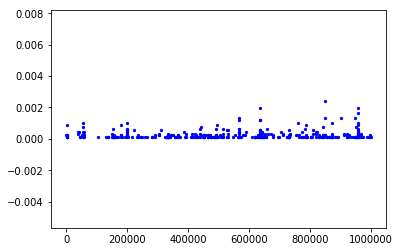

In [8]:
#get subset of data set for area surrounding each maximum



df_us = df_all[df_all.dist_from_max < 1000e3] #with dc
df_us = df_us[df_us.dist_from_max > 0]        #without dc

x = df_us.dist_from_max
y = df_us.proportion_of_total_mentions

plt.scatter(x,y,s=5,c='blue')
plt.show()

-332520389859.0


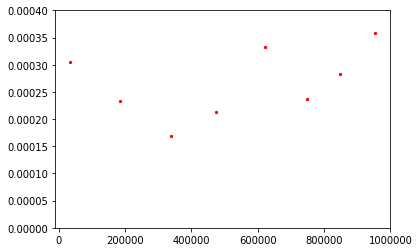

In [50]:
#kmeans clustering on df_us subset
#see http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


y = df_us.proportion_of_total_mentions
x = df_us.dist_from_max

df_data = df_us[['proportion_of_total_mentions','dist_from_max']]

kmeans = KMeans().fit(df_data)
y = kmeans.cluster_centers_[:,0]
x = kmeans.cluster_centers_[:,1]

print(kmeans.score(df_data))

plt.scatter(x,y,s=5,c='red')

# plt.xlim(-1, 1)
plt.ylim(0, 0.0004)

plt.show()

In [47]:
#see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

"""
The best value is 1 and the worst value is -1. 
Values near 0 indicate overlapping clusters. 
Negative values generally indicate that a sample has been assigned to the wrong cluster, 
as a different cluster is more similar.
"""


labels = kmeans.labels_
metrics.silhouette_score(df_data,labels)

0.65218721987378547